# Sleep Deep Analysis

Interventional sleep analysis using a 601-night feature matrix.

**Targets:** `score` (sleep quality) and `bb_charged` (sleep recovery)  
**Sections:**
1. Feature Loading & Completeness
2. Dual-Target Correlation Analysis
3. Interventional Analysis (controllable features ranked by effect size)
4. Pre-sleep Window Comparison (1/2/4/6/8h before sleep)
5. Streak & Lag Analysis

In [1]:
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, mannwhitneyu

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.dpi': 120, 'font.size': 10})

# Make sure the analysis/ directory is on sys.path
if str(Path.cwd()) not in sys.path:
    sys.path.insert(0, str(Path.cwd()))

from customized.sleep_feature_builder import (
    build_sleep_features,
    report_feature_completeness,
    CONTROLLABILITY,
)

print('Imports OK')

Imports OK


---
## Section 1 — Feature Loading & Completeness

In [2]:
df = build_sleep_features(verbose=True)

print(f'\nShape: {df.shape}')
print(f'Date range: {df["day"].min().date()} → {df["day"].max().date()}')
print(f'Nights with sleep start: {df["sleep_start_hour"].notna().sum()}/{len(df)}')

Loading sleep data...
Loading activities...
Filtered 253 nighttime activities (22:30–04:00 window)
Building exercise features...
Loading daily summary and days summary...
Loading monitoring_hr...
Loading stress...
Loading monitoring_rr...
Loading monitoring (steps/calories)...
Computing pre-sleep HR features...
Computing pre-sleep stress features...
Computing pre-sleep RR features...
Computing pre-sleep activity features...
Building sleep architecture features...
Done. Shape: (601, 146)

Shape: (601, 146)
Date range: 2024-07-01 → 2026-02-21
Nights with sleep start: 568/601


In [3]:
completeness = report_feature_completeness(df)

# Highlight partial-coverage features
def _style_completeness(row):
    if row['partial_coverage']:
        return ['background-color: #fff3cd'] * len(row)
    elif row['pct_complete'] < 50:
        return ['background-color: #f8d7da'] * len(row)
    elif row['pct_complete'] >= 90:
        return ['background-color: #d1e7dd'] * len(row)
    return [''] * len(row)

print(f'Total features: {len(completeness)}')
print(f'Features ≥90% complete: {(completeness.pct_complete >= 90).sum()}')
print(f'Features <50% complete: {(completeness.pct_complete < 50).sum()}')
print(f'Partial-coverage features (sleep_events): {completeness.partial_coverage.sum()}')
print()

# Display full table
completeness.style.apply(_style_completeness, axis=1).format({'pct_complete': '{:.1f}%'})

Total features: 146
Features ≥90% complete: 124
Features <50% complete: 20
Partial-coverage features (sleep_events): 4



,feature,non_null,total,pct_complete,partial_coverage,controllability
0,avg_spo2,0,601,0.0%,False,LOW
1,floors_up,0,601,0.0%,False,—
2,calories_goal,0,601,0.0%,False,—
3,floors_down,0,601,0.0%,False,—
4,spo2_avg,0,601,0.0%,False,—
5,description,0,601,0.0%,False,—
6,calories_consumed,0,601,0.0%,False,—
7,spo2_min,1,601,0.2%,False,—
8,time_to_first_rem_min,137,601,22.8%,True,LOW
9,n_awakenings,144,601,24.0%,True,LOW


---
## Section 2 — Dual-Target Correlation Analysis

Spearman rank correlations for all numeric features vs `score` and `bb_charged`.  
Significance threshold: p < 0.05 after Bonferroni correction.

In [4]:
def spearman_table(df: pd.DataFrame, target: str, min_samples: int = 30) -> pd.DataFrame:
    """Compute Spearman r and p-value for all numeric features vs target."""
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    # Exclude target itself and the other target
    exclude = {target, 'score', 'bb_charged', 'day'}
    feature_cols = [c for c in numeric_cols if c not in exclude]

    rows = []
    y = df[target]
    for col in feature_cols:
        mask = df[col].notna() & y.notna()
        n = mask.sum()
        if n < min_samples:
            continue
        r, p = spearmanr(df.loc[mask, col], y[mask])
        rows.append({'feature': col, 'r': r, 'p': p, 'n': n})

    result = pd.DataFrame(rows)
    # Bonferroni correction
    n_tests = len(result)
    result['p_corrected'] = (result['p'] * n_tests).clip(upper=1.0)
    result['significant'] = result['p_corrected'] < 0.05
    result['|r|'] = result['r'].abs()
    result = result.sort_values('|r|', ascending=False).reset_index(drop=True)
    return result[['feature', 'r', '|r|', 'p', 'p_corrected', 'significant', 'n']]


corr_score = spearman_table(df, 'score')
print(f'Features correlated vs score (n={len(corr_score)}):')
print(f'  Significant (Bonferroni): {corr_score.significant.sum()}')
corr_score.head(30).style.background_gradient(subset=['r'], cmap='RdYlGn', vmin=-1, vmax=1) \
    .format({'r': '{:.3f}', '|r|': '{:.3f}', 'p': '{:.4f}', 'p_corrected': '{:.4f}'})

Features correlated vs score (n=122):
  Significant (Bonferroni): 44


,feature,r,|r|,p,p_corrected,significant,n
0,rem_sleep_hours,0.826,0.826,0.0000,0.0000,True,566
1,consecutive_poor_sleep,-0.766,0.766,0.0000,0.0000,True,566
2,total_sleep_hours,0.760,0.760,0.0000,0.0000,True,566
3,time_in_bed_hours,0.695,0.695,0.0000,0.0000,True,566
4,bb_range,0.643,0.643,0.0000,0.0000,True,566
5,bb_max,0.631,0.631,0.0000,0.0000,True,566
6,pre_sleep_stress_avg_6h,-0.605,0.605,0.0000,0.0000,True,565
7,consecutive_good_sleep,0.583,0.583,0.0000,0.0000,True,566
8,pre_sleep_stress_avg_4h,-0.571,0.571,0.0000,0.0000,True,565
9,pre_sleep_stress_avg_8h,-0.568,0.568,0.0000,0.0000,True,566


In [5]:
corr_bb = spearman_table(df, 'bb_charged')
print(f'Features correlated vs bb_charged (n={len(corr_bb)}):')
print(f'  Significant (Bonferroni): {corr_bb.significant.sum()}')
corr_bb.head(30).style.background_gradient(subset=['r'], cmap='RdYlGn', vmin=-1, vmax=1) \
    .format({'r': '{:.3f}', '|r|': '{:.3f}', 'p': '{:.4f}', 'p_corrected': '{:.4f}'})

Features correlated vs bb_charged (n=122):
  Significant (Bonferroni): 58


,feature,r,|r|,p,p_corrected,significant,n
0,bb_range,0.951,0.951,0.0000,0.0000,True,588
1,bb_max,0.920,0.920,0.0000,0.0000,True,588
2,pre_sleep_stress_avg_8h,-0.810,0.810,0.0000,0.0000,True,568
3,avg_stress,-0.771,0.771,0.0000,0.0000,True,568
4,pre_sleep_stress_avg_6h,-0.750,0.750,0.0000,0.0000,True,567
5,rhr_daily,-0.682,0.682,0.0000,0.0000,True,588
6,rhr,-0.681,0.681,0.0000,0.0000,True,587
7,pre_sleep_stress_avg_4h,-0.604,0.604,0.0000,0.0000,True,567
8,stress_avg,-0.589,0.589,0.0000,0.0000,True,588
9,inactive_hr_avg,-0.589,0.589,0.0000,0.0000,True,587


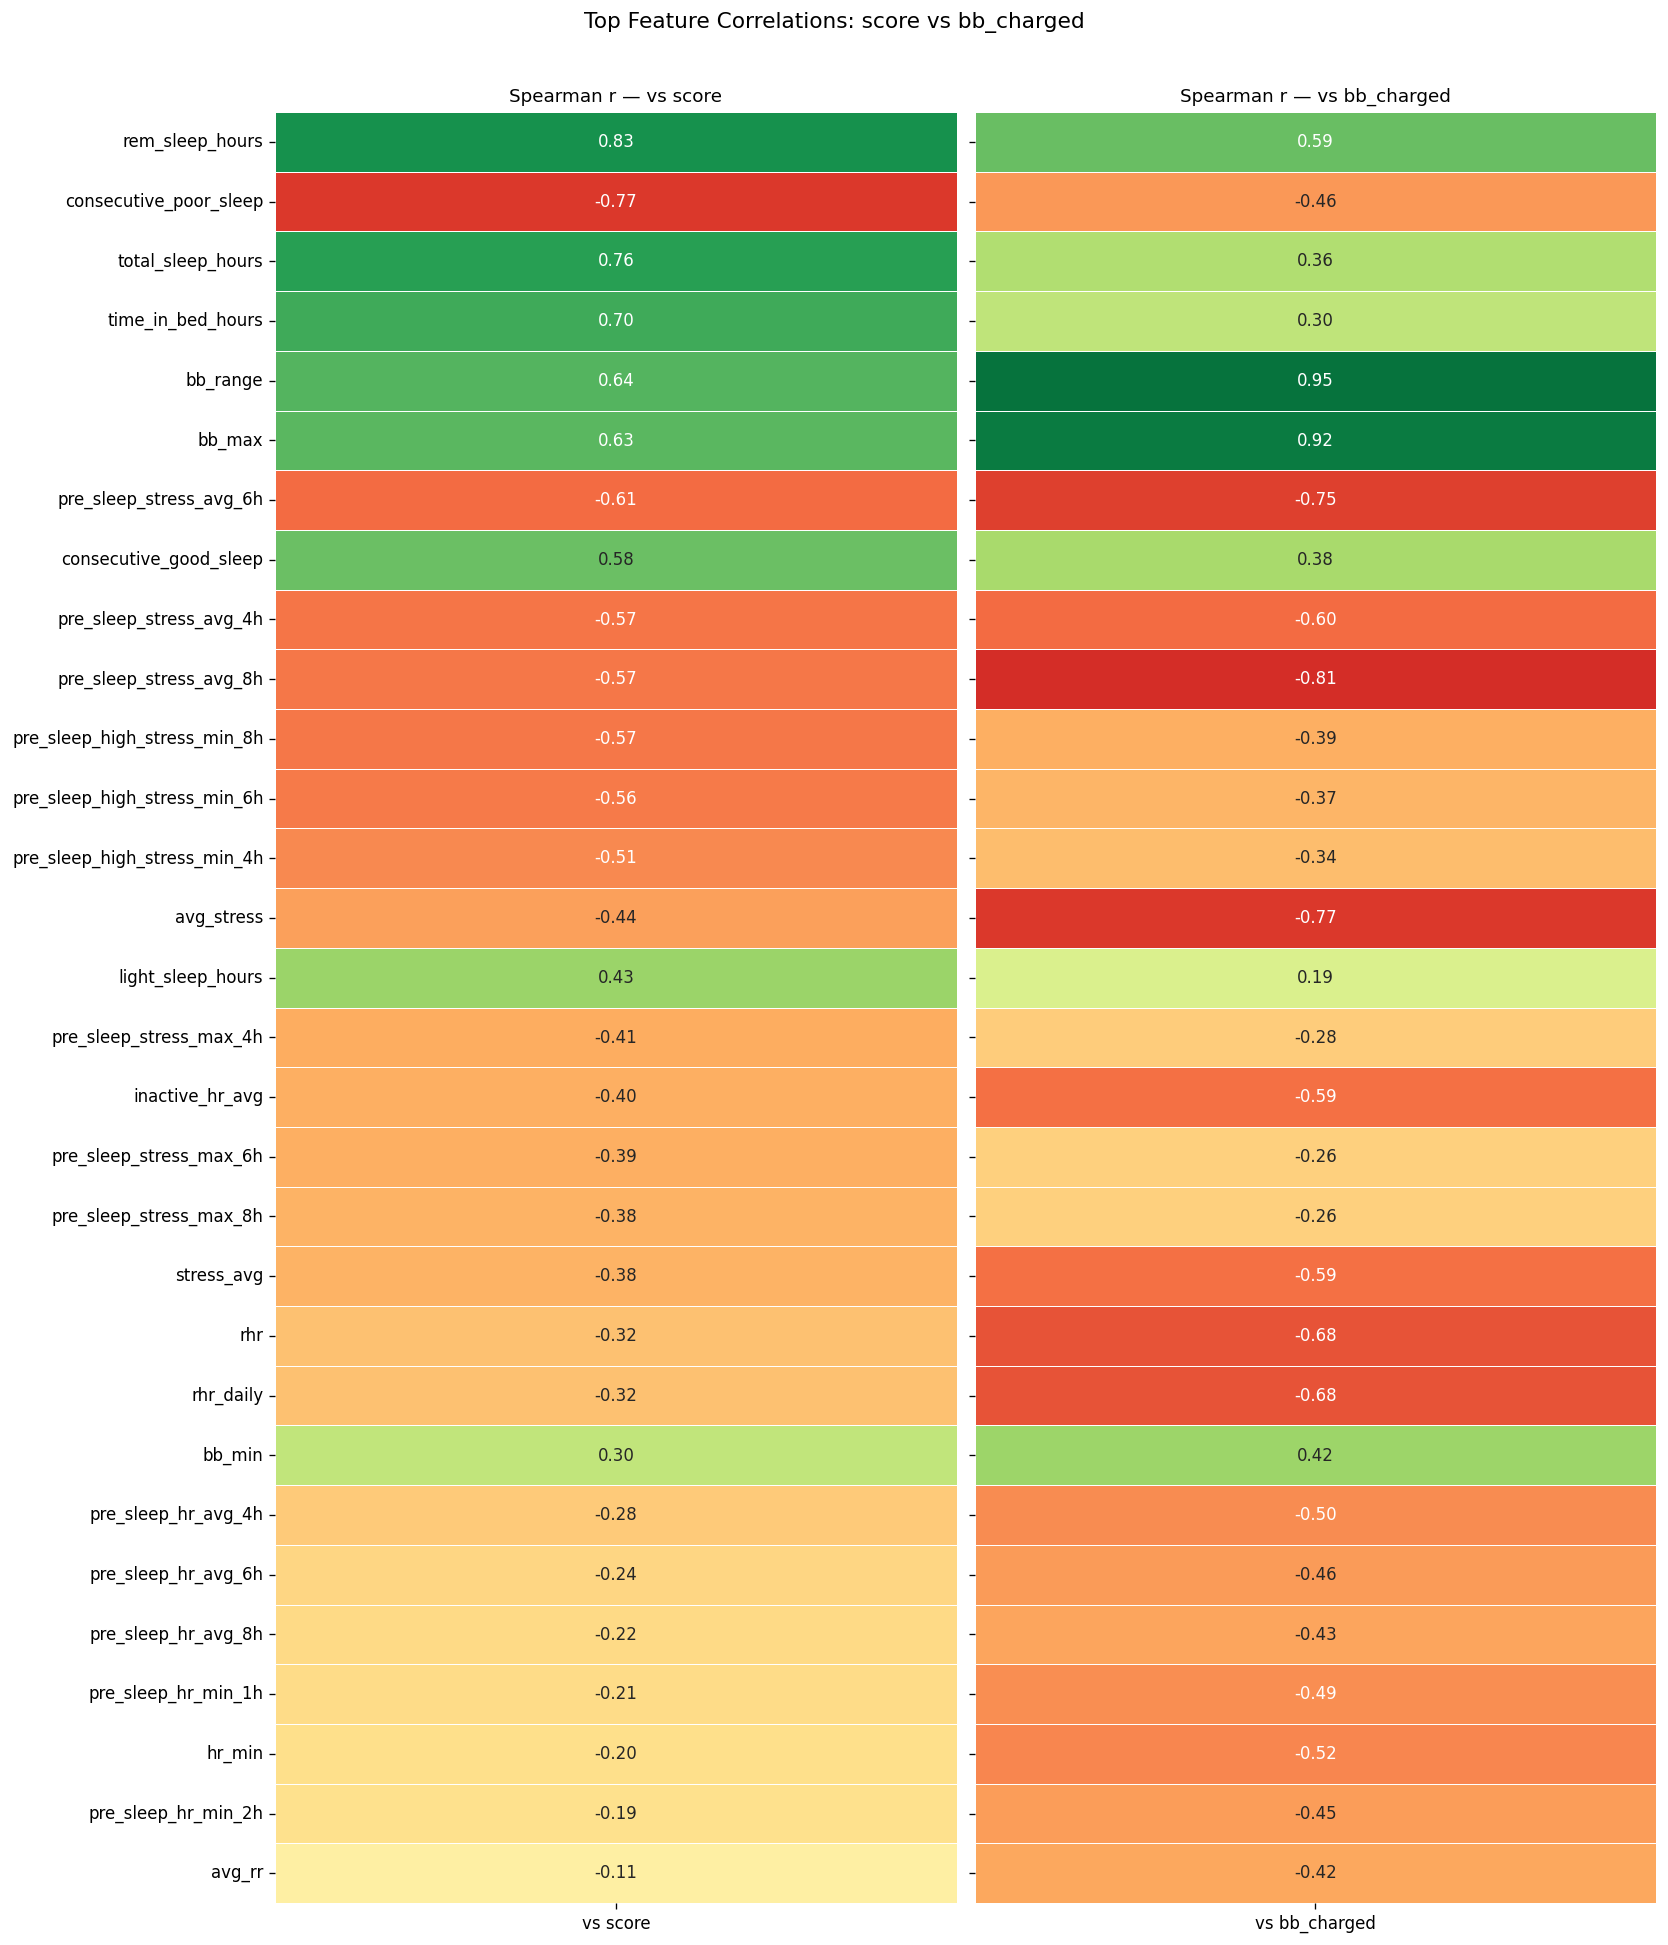

In [6]:
# Side-by-side heatmap: top-20 features for each target
top_n = 20
top_score = corr_score.head(top_n).set_index('feature')[['r']].rename(columns={'r': 'vs score'})
top_bb = corr_bb.head(top_n).set_index('feature')[['r']].rename(columns={'r': 'vs bb_charged'})

# Union of top features
all_top = sorted(set(top_score.index) | set(top_bb.index))
compare = pd.DataFrame(index=all_top)
compare['vs score'] = corr_score.set_index('feature')['r'].reindex(all_top)
compare['vs bb_charged'] = corr_bb.set_index('feature')['r'].reindex(all_top)
compare = compare.reindex(compare['vs score'].abs().sort_values(ascending=False).index)

fig, axes = plt.subplots(1, 2, figsize=(14, 0.5 * len(compare) + 1), sharey=True)
for ax, col, title in zip(axes, compare.columns, compare.columns):
    vals = compare[[col]]
    sns.heatmap(
        vals, ax=ax, annot=True, fmt='.2f', cmap='RdYlGn',
        vmin=-1, vmax=1, linewidths=0.5, cbar=False
    )
    ax.set_title(f'Spearman r — {title}', fontsize=11)
    ax.set_xlabel('')
fig.suptitle('Top Feature Correlations: score vs bb_charged', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

---
## Section 3 — Interventional Analysis

Controllable features (HIGH/MEDIUM) ranked by Mann-Whitney rank-biserial effect size  
between deprived nights (score < 60) and adequate nights (score ≥ 75).

In [7]:
# Filter to controllable features
controllable = {k for k, v in CONTROLLABILITY.items() if v in ('HIGH', 'MEDIUM')}
ctrl_cols = [c for c in df.columns if c in controllable]
print(f'Controllable features (HIGH/MEDIUM): {len(ctrl_cols)}')

# Define sleep quality groups
deprived_mask = df['score'] < 60
adequate_mask = df['score'] >= 75
deprived = df[deprived_mask]
adequate = df[adequate_mask]
print(f'Deprived nights (score<60): {len(deprived)}')
print(f'Adequate nights (score≥75): {len(adequate)}')

Controllable features (HIGH/MEDIUM): 59
Deprived nights (score<60): 159
Adequate nights (score≥75): 160


In [8]:
def rank_biserial(x1, x2):
    """Mann-Whitney rank-biserial correlation (effect size). Range [-1, 1]."""
    try:
        x1 = pd.to_numeric(x1, errors='coerce').dropna().values
        x2 = pd.to_numeric(x2, errors='coerce').dropna().values
    except Exception:
        return np.nan, np.nan, np.nan, np.nan
    if len(x1) < 5 or len(x2) < 5:
        return np.nan, np.nan, np.nan, np.nan
    u, p = mannwhitneyu(x1, x2, alternative='two-sided')
    n1, n2 = len(x1), len(x2)
    r = 1 - (2 * u) / (n1 * n2)
    return r, p, float(np.mean(x1)), float(np.mean(x2))


effect_rows = []
for col in ctrl_cols:
    r, p, mean_dep, mean_adeq = rank_biserial(deprived[col], adequate[col])
    effect_rows.append({
        'feature': col,
        'controllability': CONTROLLABILITY.get(col, '?'),
        'effect_size': r,
        '|effect|': abs(r) if not np.isnan(r) else np.nan,
        'p': p,
        'mean_deprived': mean_dep,
        'mean_adequate': mean_adeq,
    })

effects = (
    pd.DataFrame(effect_rows)
    .dropna(subset=['effect_size'])
    .sort_values('|effect|', ascending=False)
    .reset_index(drop=True)
)

print('Top 15 controllable features by |effect size| (deprived vs adequate nights):')
effects.head(15).style \
    .background_gradient(subset=['effect_size'], cmap='RdYlGn', vmin=-1, vmax=1) \
    .format({'effect_size': '{:.3f}', '|effect|': '{:.3f}', 'p': '{:.4f}',
             'mean_deprived': '{:.2f}', 'mean_adequate': '{:.2f}'})

Top 15 controllable features by |effect size| (deprived vs adequate nights):


,feature,controllability,effect_size,|effect|,p,mean_deprived,mean_adequate
0,time_in_bed_hours,HIGH,0.819,0.819,0.0000,5.23,7.66
1,pre_sleep_stress_avg_6h,HIGH,-0.768,0.768,0.0000,26.05,17.01
2,pre_sleep_stress_avg_8h,HIGH,-0.737,0.737,0.0000,25.53,17.19
3,pre_sleep_stress_avg_4h,HIGH,-0.737,0.737,0.0000,27.53,17.74
4,pre_sleep_high_stress_min_8h,HIGH,-0.732,0.732,0.0000,50.99,15.90
5,pre_sleep_high_stress_min_6h,HIGH,-0.720,0.720,0.0000,47.13,14.44
6,pre_sleep_high_stress_min_4h,HIGH,-0.670,0.670,0.0000,43.03,13.51
7,pre_sleep_stress_max_4h,MEDIUM,-0.575,0.575,0.0000,89.34,69.30
8,pre_sleep_stress_max_6h,MEDIUM,-0.556,0.556,0.0000,90.42,74.11
9,pre_sleep_stress_max_8h,MEDIUM,-0.545,0.545,0.0000,90.60,75.53


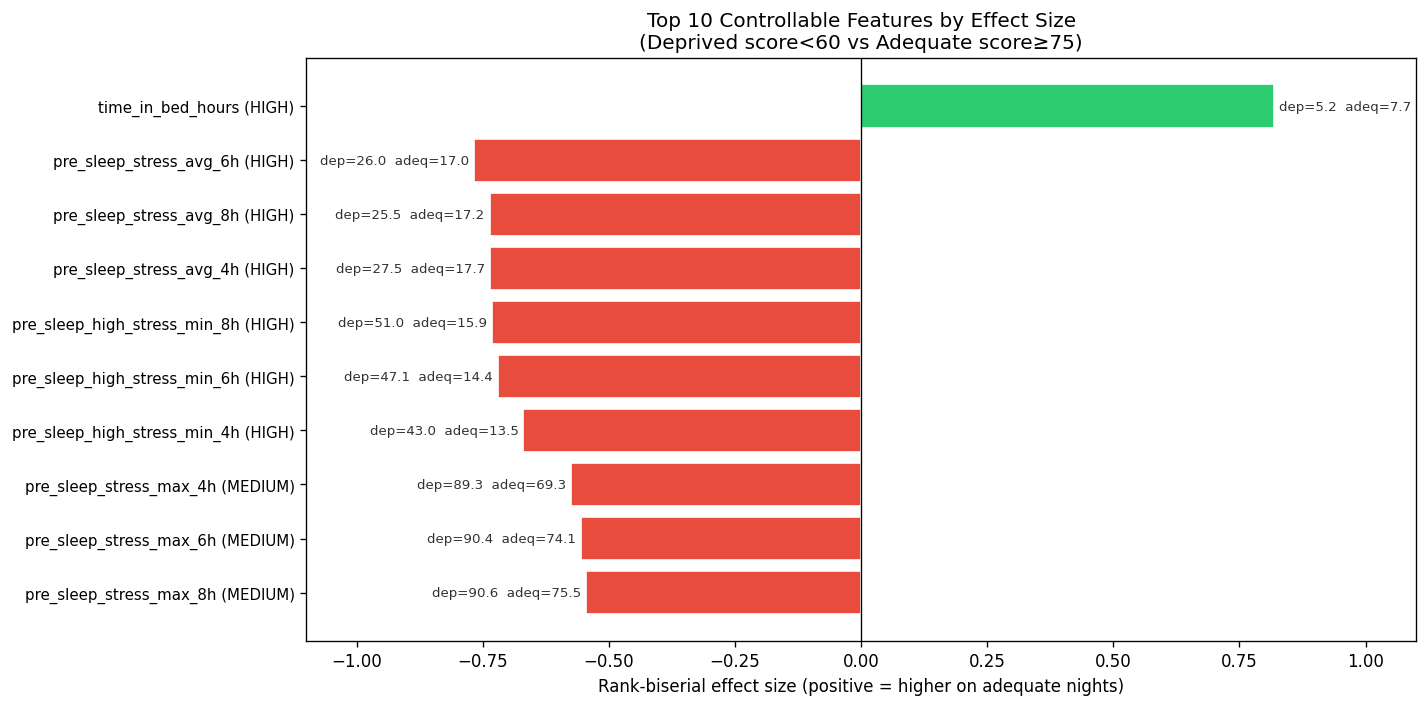

In [9]:
# Ranked bar chart of top-10 controllable features
top10 = effects.head(10).copy()

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in top10['effect_size']]
bars = ax.barh(range(len(top10)), top10['effect_size'], color=colors, edgecolor='white')

# Annotate with group means
for i, (_, row) in enumerate(top10.iterrows()):
    label = f"dep={row['mean_deprived']:.1f}  adeq={row['mean_adequate']:.1f}"
    x_pos = row['effect_size'] + (0.01 if row['effect_size'] >= 0 else -0.01)
    ha = 'left' if row['effect_size'] >= 0 else 'right'
    ax.text(x_pos, i, label, va='center', ha=ha, fontsize=8, color='#333')

ax.set_yticks(range(len(top10)))
ax.set_yticklabels(
    [f"{row['feature']} ({row['controllability']})" for _, row in top10.iterrows()],
    fontsize=9
)
ax.invert_yaxis()
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Rank-biserial effect size (positive = higher on adequate nights)')
ax.set_title('Top 10 Controllable Features by Effect Size\n(Deprived score<60 vs Adequate score≥75)')
ax.set_xlim(-1.1, 1.1)
plt.tight_layout()
plt.show()

---
## Section 4 — Pre-sleep Window Comparison

How does correlation strength vary with window length (1, 2, 4, 6, 8h before sleep)?

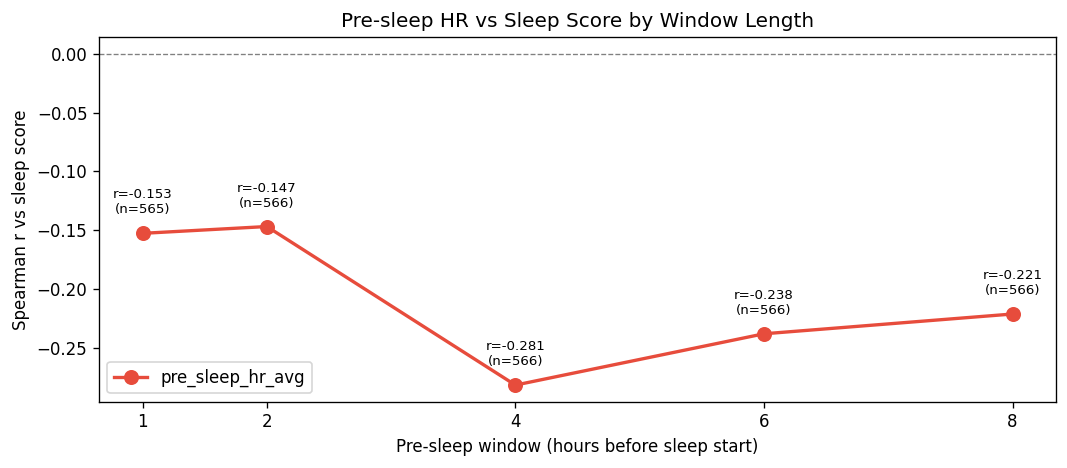

In [10]:
WINDOWS = [1, 2, 4, 6, 8]
TARGET = 'score'


def window_correlations(df, prefix, windows, target):
    rs, ps, ns = [], [], []
    for n in windows:
        col = f'{prefix}_{n}h'
        if col not in df.columns:
            rs.append(np.nan); ps.append(np.nan); ns.append(0)
            continue
        mask = df[col].notna() & df[target].notna()
        if mask.sum() < 10:
            rs.append(np.nan); ps.append(np.nan); ns.append(mask.sum())
            continue
        r, p = spearmanr(df.loc[mask, col], df.loc[mask, target])
        rs.append(r); ps.append(p); ns.append(mask.sum())
    return rs, ps, ns


# HR
hr_r, hr_p, hr_n = window_correlations(df, 'pre_sleep_hr_avg', WINDOWS, TARGET)

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(WINDOWS, hr_r, 'o-', color='#e74c3c', linewidth=2, markersize=8, label='pre_sleep_hr_avg')
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)

for x, r, n in zip(WINDOWS, hr_r, hr_n):
    if not np.isnan(r):
        ax.annotate(f'r={r:.3f}\n(n={n})', (x, r), textcoords='offset points',
                    xytext=(0, 12), ha='center', fontsize=8)

ax.set_xlabel('Pre-sleep window (hours before sleep start)')
ax.set_ylabel('Spearman r vs sleep score')
ax.set_title('Pre-sleep HR vs Sleep Score by Window Length')
ax.set_xticks(WINDOWS)
ax.legend()
plt.tight_layout()
plt.show()

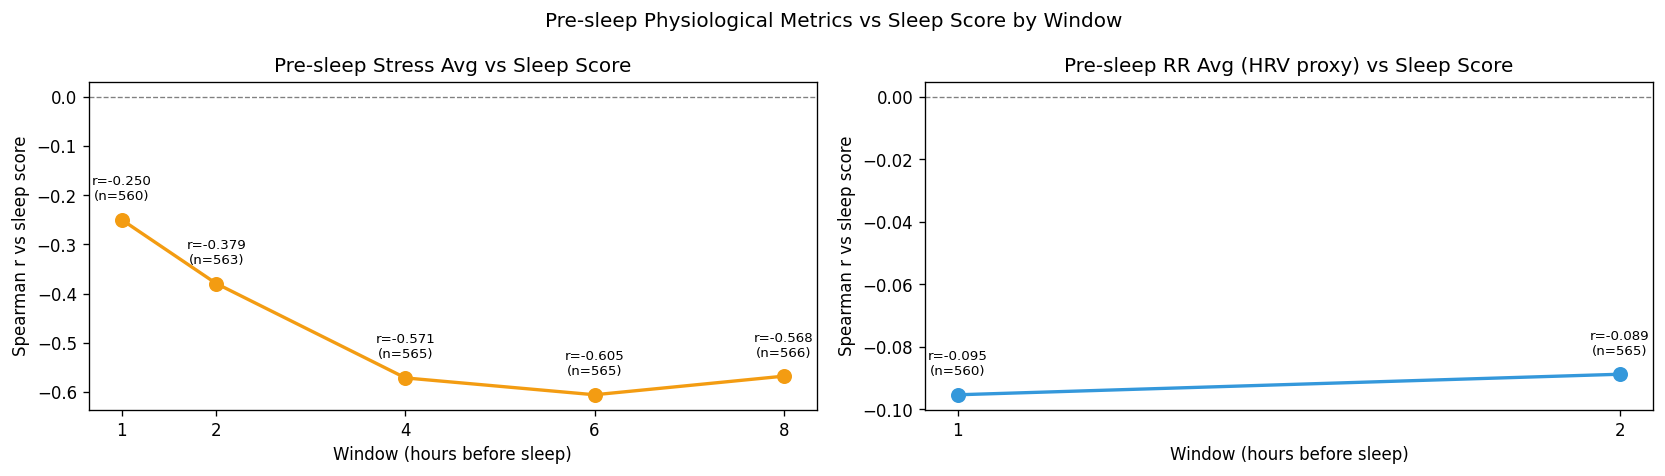

In [11]:
# Stress and RR comparison (RR only has 1h, 2h)
stress_r, stress_p, stress_n = window_correlations(df, 'pre_sleep_stress_avg', WINDOWS, TARGET)
rr_r, rr_p, rr_n = window_correlations(df, 'pre_sleep_rr_avg', [1, 2], TARGET)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Stress
ax = axes[0]
ax.plot(WINDOWS, stress_r, 'o-', color='#f39c12', linewidth=2, markersize=8)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
for x, r, n in zip(WINDOWS, stress_r, stress_n):
    if not np.isnan(r):
        ax.annotate(f'r={r:.3f}\n(n={n})', (x, r), textcoords='offset points',
                    xytext=(0, 12), ha='center', fontsize=8)
ax.set_xlabel('Window (hours before sleep)')
ax.set_ylabel('Spearman r vs sleep score')
ax.set_title('Pre-sleep Stress Avg vs Sleep Score')
ax.set_xticks(WINDOWS)

# RR
ax = axes[1]
ax.plot([1, 2], rr_r, 'o-', color='#3498db', linewidth=2, markersize=8)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
for x, r, n in zip([1, 2], rr_r, rr_n):
    if not np.isnan(r):
        ax.annotate(f'r={r:.3f}\n(n={n})', (x, r), textcoords='offset points',
                    xytext=(0, 12), ha='center', fontsize=8)
ax.set_xlabel('Window (hours before sleep)')
ax.set_ylabel('Spearman r vs sleep score')
ax.set_title('Pre-sleep RR Avg (HRV proxy) vs Sleep Score')
ax.set_xticks([1, 2])

plt.suptitle('Pre-sleep Physiological Metrics vs Sleep Score by Window', fontsize=12)
plt.tight_layout()
plt.show()

---
## Section 5 — Streak & Lag Analysis

How do accumulated sleep debt and exercise streaks relate to sleep quality?

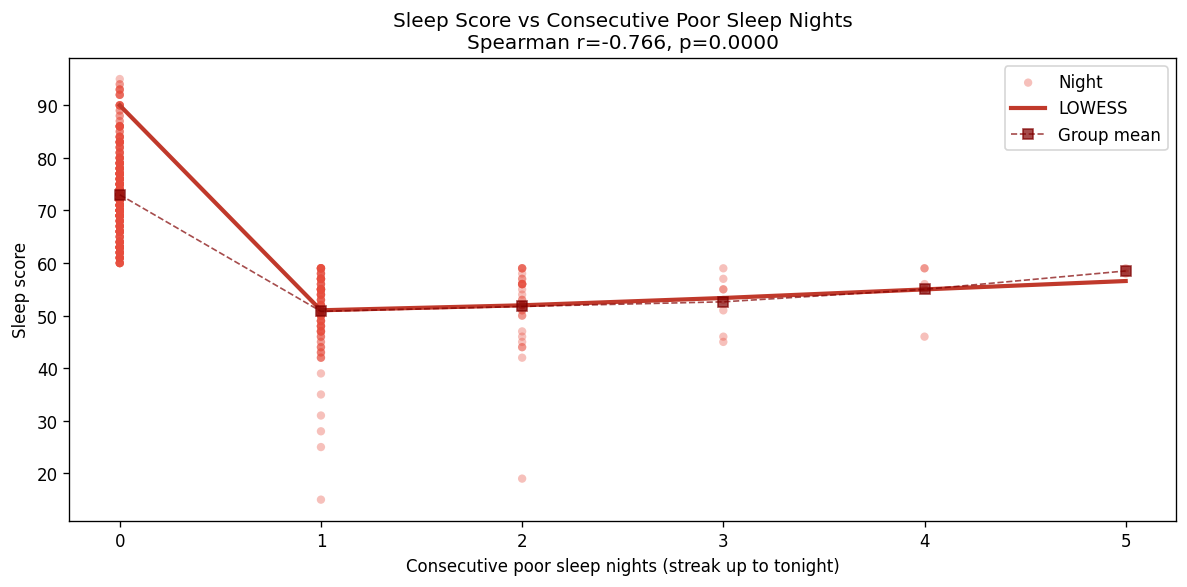

In [12]:
# Scatter + LOWESS: sleep score vs consecutive_poor_sleep
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    HAS_LOWESS = True
except ImportError:
    HAS_LOWESS = False
    print('statsmodels not available; LOWESS curve skipped')

sub = df[df['consecutive_poor_sleep'].notna() & df['score'].notna()].copy()

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(
    sub['consecutive_poor_sleep'], sub['score'],
    alpha=0.35, s=25, color='#e74c3c', edgecolors='none', label='Night'
)

if HAS_LOWESS and len(sub) > 10:
    smooth = lowess(sub['score'], sub['consecutive_poor_sleep'], frac=0.4)
    ax.plot(smooth[:, 0], smooth[:, 1], color='#c0392b', linewidth=2.5, label='LOWESS')

# Group means
means = sub.groupby('consecutive_poor_sleep')['score'].mean()
ax.plot(means.index, means.values, 's--', color='#800000', markersize=6,
        linewidth=1, label='Group mean', alpha=0.7)

r, p = spearmanr(sub['consecutive_poor_sleep'], sub['score'])
ax.set_xlabel('Consecutive poor sleep nights (streak up to tonight)')
ax.set_ylabel('Sleep score')
ax.set_title(f'Sleep Score vs Consecutive Poor Sleep Nights\nSpearman r={r:.3f}, p={p:.4f}')
ax.legend()
plt.tight_layout()
plt.show()

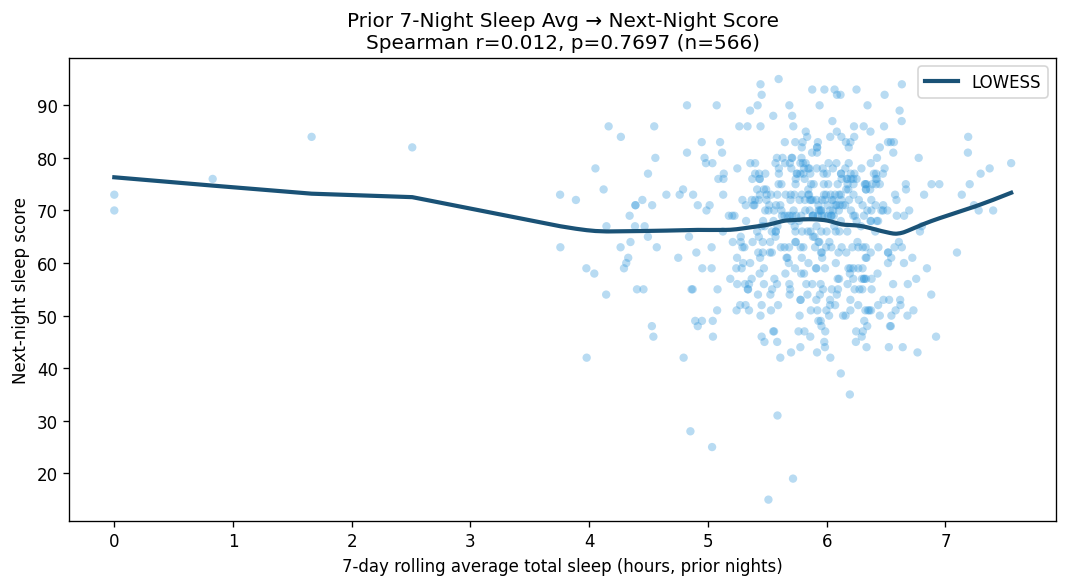

rolling_7d_sleep_avg vs next_night_score: r=0.012, p=0.7697


In [13]:
# Correlation of rolling_7d_sleep_avg with NEXT-NIGHT score
df_lag = df.copy()
df_lag['next_night_score'] = df_lag['score'].shift(-1)

sub2 = df_lag[df_lag['rolling_7d_sleep_avg'].notna() & df_lag['next_night_score'].notna()]
r_lag, p_lag = spearmanr(sub2['rolling_7d_sleep_avg'], sub2['next_night_score'])

fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(
    sub2['rolling_7d_sleep_avg'], sub2['next_night_score'],
    alpha=0.35, s=25, color='#3498db', edgecolors='none'
)

if HAS_LOWESS and len(sub2) > 10:
    smooth2 = lowess(sub2['next_night_score'], sub2['rolling_7d_sleep_avg'], frac=0.5)
    ax.plot(smooth2[:, 0], smooth2[:, 1], color='#1a5276', linewidth=2.5, label='LOWESS')
    ax.legend()

ax.set_xlabel('7-day rolling average total sleep (hours, prior nights)')
ax.set_ylabel('Next-night sleep score')
ax.set_title(f'Prior 7-Night Sleep Avg → Next-Night Score\nSpearman r={r_lag:.3f}, p={p_lag:.4f} (n={len(sub2)})')
plt.tight_layout()
plt.show()

print(f'rolling_7d_sleep_avg vs next_night_score: r={r_lag:.3f}, p={p_lag:.4f}')

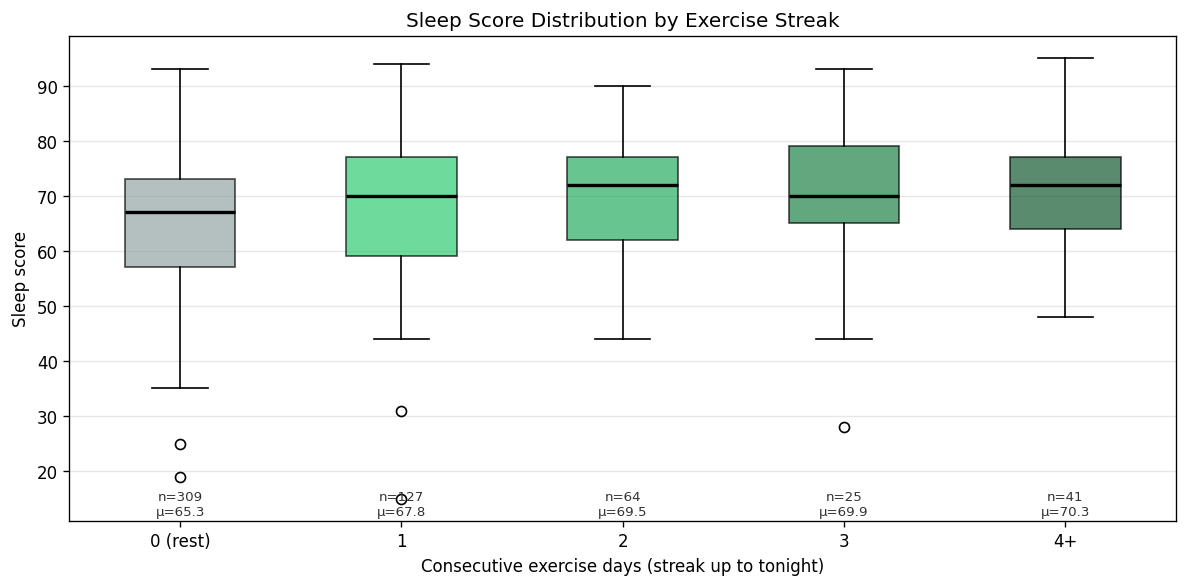

Kruskal-Wallis H=14.48, p=0.0059


In [14]:
# Box plot: sleep score by consecutive_exercise_days bucket
def bucket_exercise(n):
    if n == 0: return '0 (rest)'
    if n == 1: return '1'
    if n == 2: return '2'
    if n == 3: return '3'
    return '4+'

df_ex = df[df['consecutive_exercise_days'].notna() & df['score'].notna()].copy()
df_ex['ex_bucket'] = df_ex['consecutive_exercise_days'].apply(bucket_exercise)

bucket_order = ['0 (rest)', '1', '2', '3', '4+']
bucket_order = [b for b in bucket_order if b in df_ex['ex_bucket'].unique()]

fig, ax = plt.subplots(figsize=(10, 5))

groups = [df_ex[df_ex['ex_bucket'] == b]['score'].dropna().values for b in bucket_order]
bp = ax.boxplot(groups, labels=bucket_order, patch_artist=True, notch=False,
                medianprops={'color': 'black', 'linewidth': 2})

colors = ['#95a5a6', '#2ecc71', '#27ae60', '#1e8449', '#145a32']
for patch, color in zip(bp['boxes'], colors[:len(bucket_order)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Annotate with counts and means
for i, (grp, label) in enumerate(zip(groups, bucket_order)):
    if len(grp) > 0:
        ax.text(i + 1, ax.get_ylim()[0] + 1, f'n={len(grp)}\nμ={np.mean(grp):.1f}',
                ha='center', fontsize=8, color='#333')

ax.set_xlabel('Consecutive exercise days (streak up to tonight)')
ax.set_ylabel('Sleep score')
ax.set_title('Sleep Score Distribution by Exercise Streak')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Kruskal-Wallis test
valid_groups = [g for g in groups if len(g) >= 5]
if len(valid_groups) >= 2:
    h, p_kw = stats.kruskal(*valid_groups)
    print(f'Kruskal-Wallis H={h:.2f}, p={p_kw:.4f}')